In [2]:
# https://github.com/Vishwa22/Multi-Label-Text-Classification/blob/master/MultilabelClassification.ipynb

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [2]:
toxic_comments = pd.read_csv("train.csv")

In [3]:
print(toxic_comments.shape)

toxic_comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [5]:
print(toxic_comments["comment_text"][168])

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [6]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [7]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


<Axes: >

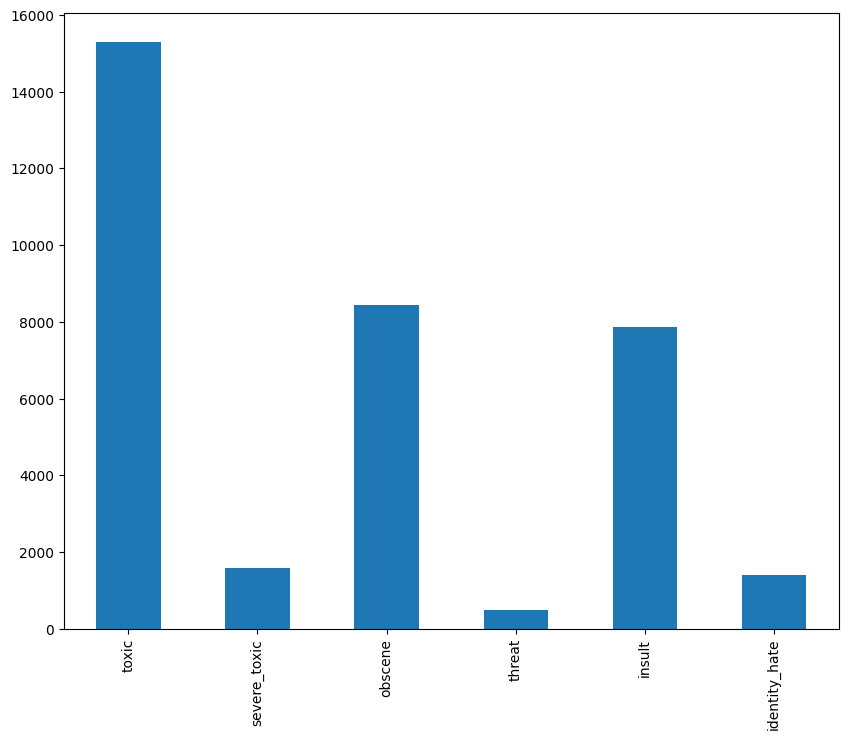

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [9]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [10]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [41]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [42]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          14824300  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 14942322 (57.00 MB)
Trainable params: 118022 (461.02 KB)
Non-trainable params: 14824300 (56.55 MB)
_________________________________________________________________
None


In [43]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [89]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
798/798 [==============================] - 354s 444ms/step - loss: 0.0663 - acc: 0.9915 - val_loss: 0.0605 - val_acc: 0.9937
Epoch 2/50
798/798 [==============================] - 395s 495ms/step - loss: 0.0630 - acc: 0.9916 - val_loss: 0.0636 - val_acc: 0.9860
Epoch 3/50
798/798 [==============================] - 403s 505ms/step - loss: 0.0582 - acc: 0.9934 - val_loss: 0.0576 - val_acc: 0.9943
Epoch 4/50
798/798 [==============================] - 10973s 14s/step - loss: 0.0549 - acc: 0.9939 - val_loss: 0.0567 - val_acc: 0.9942
Epoch 5/50
798/798 [==============================] - 346s 434ms/step - loss: 0.0533 - acc: 0.9939 - val_loss: 0.0550 - val_acc: 0.9942
Epoch 6/50
798/798 [==============================] - 400s 501ms/step - loss: 0.0517 - acc: 0.9941 - val_loss: 0.0547 - val_acc: 0.9943
Epoch 7/50
798/798 [==============================] - 467s 586ms/step - loss: 0.0504 - acc: 0.9940 - val_loss: 0.0547 - val_acc: 0.9937
Epoch 8/50
798/798 [============================

In [94]:
print('hjhj')

hjhj


In [93]:
pwd

'C:\\Users\\MSALMANN\\Work_dir\\Projects\\dell\\context_anomaly'

In [107]:
model.save('model_ml_classifier.h5')

C:\Users\MSALMANN\Anaconda3\Anaconda3\envs\track\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [95]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 55s 55ms/step - loss: 0.1000 - acc: 0.1032
Test Score: 0.0999956801533699
Test Accuracy: 0.1032116562128067


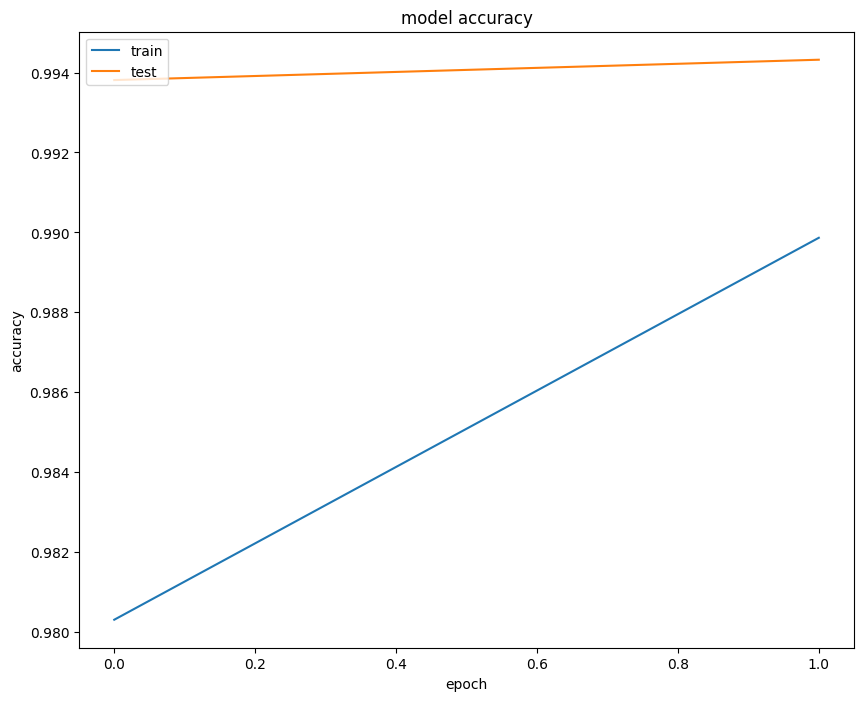

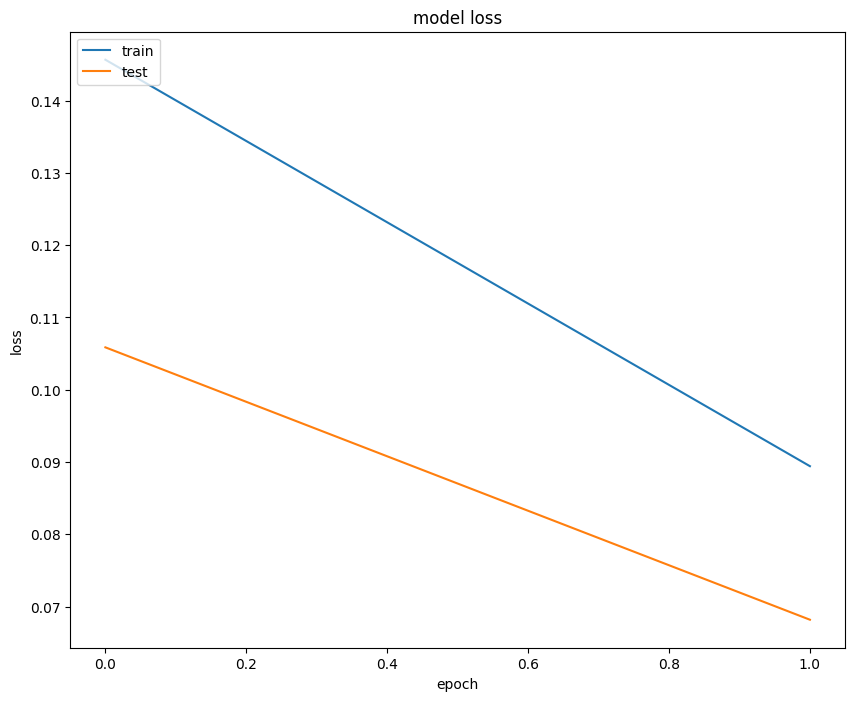

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [61]:
toxic_comments['gh'] = toxic_comments.apply(lambda x: x.toxic+x.severe_toxic+x.obscene+x.threat+x.insult+x.identity_hate, axis=1)

In [62]:
toxic_comments[toxic_comments['gh']!=0]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,gh
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,1
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,1
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,3
...,...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,4
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,3
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,2


In [88]:
new_comment = [toxic_comments.loc[43].comment_text]
seq = tokenizer.texts_to_sequences(new_comment)
padded = pad_sequences(seq, maxlen=maxlen)
pred = model.predict(padded)
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
[(labels[idx],x) if x>0.5 else ('Normal',x) for idx, x in enumerate(pred[0])]

[('toxic', 0.7941986),
 ('Normal', 0.14295311),
 ('obscene', 0.67907226),
 ('Normal', 0.05145515),
 ('insult', 0.6222574),
 ('Normal', 0.120512836)]

In [ ]:
input : log_line
output : issue types

In [ ]:
Dataset 
Script preperation
Training
Evaluation

In [99]:
import pandas as pd

In [106]:
pd.DataFrame([['salman','munammad',1,'valiyakath']], columns=['one','two','three','four']).to_csv('sample.csv',index=False)